This notebook uses `numpyro` and replicates experiments in references [1] and [2] which evaluates the performance of HMC/NUTS on various frameworks.

In [1]:
%matplotlib inline

import time

import matplotlib.pyplot as plt
import numpy as onp
from sklearn.datasets import fetch_covtype

import jax.numpy as np
from jax import lax, random

import numpyro.distributions as dist
from numpyro.distributions.util import validation_disabled
from numpyro.handlers import sample
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import hmc_kernel
from numpyro.util import tscan, control_flow_prims_disabled

/home/fehiepsi/miniconda3/envs/pydata/lib/python3.6/site-packages/jax/lib/xla_bridge.py:144: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


We do preprocessing steps as in [source code](https://github.com/google-research/google-research/blob/master/simple_probabilistic_programming/no_u_turn_sampler/logistic_regression.py) of reference [1].

In [2]:
data = fetch_covtype()
features = data.data
labels = data.target

# normalize features and add intercept
features = (features - features.mean(0)) / features.std(0)
features = np.hstack([features, np.ones((features.shape[0], 1))])

# make binary feature
_, counts = onp.unique(labels, return_counts=True)
specific_category = np.argmax(counts)
labels = (labels == specific_category)

N, dim = features.shape
print("Data shape:", features.shape)
print("Label distribution: {} has label 1, {} has label 0".format(labels.sum(), N - labels.sum()))

Data shape: (581012, 55)
Label distribution: 211840 has label 1, 369172 has label 0


Construct model

In [3]:
def model(data, labels):
    coefs = sample('coefs', dist.norm(np.zeros(dim), np.ones(dim)))
    logits = np.dot(data, coefs)
    return sample('obs', dist.bernoulli(logits, is_logits=True), obs=labels)

### Benchmark HMC against Edward

In [4]:
num_steps, warmup_steps, num_samples = 10, 0, 100
step_size = np.sqrt(0.5 / N)
init_params = {"coefs": np.zeros(dim)}

In [5]:
with validation_disabled():
    start = time.time()
    _, potential_fn = initialize_model(random.PRNGKey(1), model, (features, labels,), {})
    print("time to create potential:", time.time() - start)

    start = time.time()
    init_kernel, sample_kernel = hmc_kernel(potential_fn, algo="HMC")
    hmc_state = init_kernel(init_params, step_size=step_size, num_steps=num_steps, adapt_step_size=False,
                            num_warmup_steps=warmup_steps)
    print("time to warmup and init :", time.time() - start)

    start = time.time()
    hmc_states = tscan(lambda state, i: sample_kernel(state), hmc_state, np.arange(1),
                       transform=lambda state: (state.z, state.num_steps))
    setup_time = time.time() - start
    print("time to setup scan loop :", setup_time)

    start = time.time()
    hmc_states = tscan(lambda state, i: sample_kernel(state), hmc_state, np.arange(num_samples + 1),
                       transform=lambda state: (state.z, state.num_steps))
    sampling_time = time.time() - start - setup_time
    num_leapfrogs = np.sum(hmc_states[1][1:]).copy()
    print("time to get 100 samples :", sampling_time)
    print("number of leapfrog steps:", num_leapfrogs)
    print("avg. time for each step :", sampling_time / num_leapfrogs)

time to create potential: 0.47363877296447754
time to warmup and init : 4.391263484954834
time to setup scan loop : 3.452260971069336
time to get 100 samples : 91.83263611793518
number of leapfrog steps: 1000
avg. time for each step : 0.09183263611793518


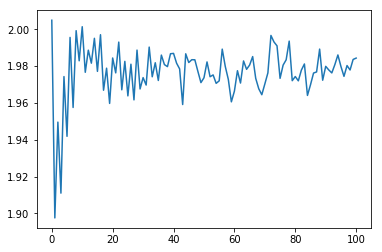

In [6]:
plt.plot(hmc_states[0]["coefs"][:, 0]);

In [7]:
import tensorflow as tf
import edward as ed

print("tensorflow version:", tf.__version__)
print("edward version:", ed.__version__)

ed.set_seed(0)
coefs = ed.models.Normal(loc=tf.zeros(dim), scale=tf.ones(dim))
logits = tf.tensordot(features.copy(), coefs, [[1], [0]])
y = ed.models.BernoulliWithSigmoidProbs(logits)

qcoefs = ed.models.Empirical(params=tf.Variable(tf.zeros([num_samples, dim])))
inference = ed.HMC({coefs: qcoefs}, data={y: labels.copy().astype(np.float32)})
inference.run(step_size=step_size.copy(), n_steps=num_steps)

tensorflow version: 1.6.0
edward version: 1.3.5


/home/fehiepsi/miniconda3/envs/pydata/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


100/100 [100%] ██████████████████████████████ Elapsed: 54s | Acceptance Rate: 0.980


### References

1. `Deep Probabilistic Programming`, [arxiv](https://arxiv.org/abs/1701.03757)<br/>
Dustin Tran, Matthew D. Hoffman, Rif A. Saurous, Eugene Brevdo, Kevin Murphy, David M. Blei

2. `Simple, Distributed, and Accelerated Probabilistic Programming,` [arxiv](https://arxiv.org/abs/1811.02091)<br/>
Dustin Tran, Matthew D. Hoffman, Dave Moore, Christopher Suter, Srinivas Vasudevan, Alexey Radul, Matthew Johnson, Rif A. Saurous